#### Summary: 
We initially found cell type-specific motifs by running HOMER on the entropy cREs, however these results were confusing... Many motifs were for TFs not expressed in the cell type, or there were repeats across cell types. Because we know TF motifs can be super similar between family members, it's likely multiple TFs could bind these motifs. To figure out which, I'll try correlating the chromvar devscores per donor against the per donor gene expression of family members. If that doesn't work, the easiest thing would be to just take any family members with some cell type expression.

In [1]:
# suppressMessages(library(hdf5r))
# suppressMessages(library(Seurat))
# suppressMessages(library(Signac))

suppressMessages(library(dplyr))
suppressMessages(library(stringr))
suppressMessages(library(data.table))
suppressMessages(library(tictoc))

suppressMessages(library(ggplot2))
suppressMessages(library(ggpubr))
suppressMessages(library(ggrepel))
suppressMessages(library(RColorBrewer))
suppressMessages(library(shadowtext))
suppressMessages(library(forcats))

#suppressMessages(library(pheatmap))
#suppressMessages(library(pracma))
#suppressMessages(library(GenomicRanges))

In [2]:
celltypes <- c('beta','alpha','delta','gamma','acinar','ductal','endothelial','stellate','immune')
rna_celltypes <- c('beta','alpha','delta','acinar','ductal','stellate','immune')
atac_celltypes <- c('beta','alpha','delta','gamma','acinar','ductal')

In [3]:
traits <- c('scaled_age','scaled_BMI','scaled_HbA1c','sex')
traits2 <- c('Age','BMI','HbA1c','Sex')
names(traits2) <- traits

In [4]:
# Set up color palettes

major_colors = c('acinar'='#09850B', 'alpha'='#F51646', 'beta'='#3F98E0',
                 'delta'='#FFA946', 'ductal'='#F5DE6C', 'endothelial'='#752BBA', 
                 'gamma'='#A1D99B', 'immune'='#F598C9', 'stellate'='#AB7345')
# options(repr.plot.width=5, repr.plot.height=5)
# scales::show_col(major_colors, cex_label=2)

In [5]:
#make RNA and ATAC specific diverging color palettes
rna_pal <- c('#D73027','#E6938E','#F5F5F5','#94B5E1','#3375CC')
atac_pal <- c('#E67925','#EEB78D','#F5F5F5','#9A96CB','#3E37A1')

# par(mfrow=c(1,2))
# scales::show_col(rna_pal, cex_label=2)
# scales::show_col(atac_pal, cex_label=2)

In [6]:
theme_set(theme_classic())

# Inputs

In [167]:
#directories for inputs
tpm_dir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/rna_profiles/recluster_final_clustering_v2/sample_TPM'
motif_dir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/atac_profiles/recluster_final_clustering_v2/donor_motif_devscores'
homer_dir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/entropy_outputs/HOMER_ATAC_ct_spec_cREs'

In [8]:
#motif family maps from Weston
lookup_fp <- '/nfs/lab/welison/References/220907_WE_Chromvar_to_Gene_By_Subfam_Complete(JAPRAR2022_TFClass).csv'
full_fp <- '/nfs/lab/welison/References/220907_WE_Chromvar_to_Gene_Jaspar2022.csv'

In [9]:
#read in motif family map and reformat a bit
motif_map <- read.table(lookup_fp, sep=',', header=1)
head(motif_map)

,full_jaspar_motif,jaspar_motif,lowest_level_family,gene
,<chr>,<chr>,<chr>,<chr>
1,MA0030.1_FOXF2,FOXF2,FOXF,FOXF2
2,MA0030.1_FOXF2,FOXF2,FOXF,FOXF1
3,MA0031.1_FOXD1,FOXD1,FOXD,FOXD1
4,MA0031.1_FOXD1,FOXD1,FOXD,FOXD2
5,MA0031.1_FOXD1,FOXD1,FOXD,FOXD3
6,MA0031.1_FOXD1,FOXD1,FOXD,FOXD4L1


# Functions

In [122]:
### Function to run correlation test and return results 
cortest_motif_gene <- function(motif, gene, motif_df, tpm_df){
    res <- cor.test(unlist(motif_df[motif,]), unlist(tpm_df[gene,]),alternative='two.sided', method='spearman')
    avg_gex <- rowMeans(tpm_df[gene,])
    results_vector <- c(res$estimate,res$p.value,avg_gex)
    return(results_vector)
}

In [168]:
get_motif_matches <- function(homer_motif, jaspar_motifs){
    motifs <- jaspar_motifs[grepl(str_to_upper(homer_motif),jaspar_motifs)]
    if(length(motifs) > 0) {
        return(paste(motifs,collapse=','))
    } else {
        return(NA)
    }
}

In [203]:
### Big wrapper function to read in entropy cRE homer results, map to jaspar motifs and genes,
### then correlate gene expression with motif accessibility (by donor) and save out results
motif_gene_cortest_wrapper <- function(celltype, outdir){
    #read in per-donor tpm and devscore files
    tpm_fp <- file.path(tpm_dir,sprintf('%s_sample_gex_TPM_wHPAPND.txt',celltype))
    tpm_df <- read.table(tpm_fp, sep='\t')
    tpm_df <- tpm_df[,grepl('R',colnames(tpm_df))]
    motif_fp <- file.path(motif_dir,sprintf('%s_Alberta_donor_devscores_ChromVAR_fin.txt',celltype))
    motif_df <- read.table(motif_fp, sep='\t')

    #read in the homer motif results and clean up a lot
    homer_fp <- file.path(homer_dir,celltype,'knownResults.txt')
    homer <- fread(homer_fp)
    colnames(homer) <- c('motif','consensus','pval','log_pval','qval','target_seq_w_motif','perc_target_seq_w_motif','bg_seq_w_motif','perc_bg_seq_w_motif')    
    homer$perc_target_seq_w_motif <- gsub("[%]", "", homer$perc_target_seq_w_motif) #remove percents
    homer$perc_bg_seq_w_motif <- gsub("[%]", "", homer$perc_bg_seq_w_motif)
    homer <- homer %>% select(-c(consensus,target_seq_w_motif,bg_seq_w_motif)) %>%
                mutate(motif_short=gsub("/.*",'',motif)) %>% mutate(motif_short=gsub("[(].*", "", motif_short)) %>% #shorten motif names to TFs
                mutate_at(c('perc_target_seq_w_motif','perc_bg_seq_w_motif'),as.numeric) %>% #convert percents to numeric
                mutate(fc=(perc_target_seq_w_motif-perc_bg_seq_w_motif)/perc_bg_seq_w_motif) #calculate foldchange
    homer$padj <- p.adjust(homer$pval,method='BH')

    #map sig homer motifs to JASPAR motifs
    homer_sig <- subset(homer, padj < 0.1)
    matches <- lapply(homer_sig$motif_short, get_motif_matches, row.names(motif_df))
    match_df <- data.frame(motif_short=homer_sig$motif_short, motif_jaspar=unlist(matches)) %>%
                    tidyr::separate_rows(motif_jaspar, sep=',')
    homer_fin <- left_join(homer_sig, match_df, by='motif_short')

    #now map in all family member genes
    jaspar_motifs <- unique(subset(homer_fin, motif_jaspar!='') %>% pull(motif_jaspar))
    gene_map <- subset(motif_map, full_jaspar_motif %in% jaspar_motifs) %>%
                    select(full_jaspar_motif,gene) %>%
                    rename(motif_jaspar=full_jaspar_motif)
    homer_fin2 <- as.data.frame(left_join(homer_fin, gene_map, by='motif_jaspar'))
        
    #run cor.test on all motif and gene pairs, save to df
    results_df <- data.frame()
    for(row in seq(dim(homer_fin2)[1])){
        motif <- unlist(homer_fin2[row,'motif_jaspar'])
        gene <- unlist(homer_fin2[row,'gene'])
        if((gene %in% row.names(tpm_df) & (motif %in% row.names(motif_df)))){
            cor_res <- suppressWarnings(cortest_motif_gene(motif, gene, motif_df, tpm_df))
            results <- c(cor_res, motif, gene)
            results_df <- rbind(results_df,results)
        }
    }
    colnames(results_df) <- c('cor_estimate','cor_pvalue','avg_TPM','motif_jaspar','gene')
    results <- left_join(homer_fin2, results_df, by=c('motif_jaspar','gene'))
    results$cor_padj <- p.adjust(results$cor_pvalue, method='BH')
    
    #write results to a file!
    fp1 <- file.path(outdir,sprintf('%s_all_entropy_cRE_HOMER_motif_gene_corrs.txt',celltype))
    fp2 <- file.path(outdir,sprintf('%s_sig_avg_TPM1_pos_corr_entropy_cRE_HOMER_motif_gene_corrs.txt',celltype))
    write.table(results, fp1, sep='\t', row.names=FALSE, quote=FALSE)
    write.table(subset(results, avg_TPM > 1 & cor_padj < 0.1 & cor_estimate > 0), fp2, sep='\t', row.names=FALSE, quote=FALSE)
}

## Test code -- convert to wrapper

In [170]:
outdir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/entropy_outputs/HOMER_ATAC_ct_spec_cREs/motif_gene_corrs'

In [204]:
for(celltype in celltypes){
    motif_gene_cortest_wrapper(celltype,outdir)
}

In [205]:
#summarize sig results
for(celltype in celltypes){
    print(celltype)
    
    #read in sig results
    res_fp <- file.path(outdir,sprintf('%s_sig_avg_TPM1_pos_corr_entropy_cRE_HOMER_motif_gene_corrs.txt',celltype))
    if(file.exists(res_fp)){
        res <- read.table(res_fp, sep='\t', header=1)

        #print unique genes in sig results
        unique_tfs <- sort(unique(res$gene))
        print(unique_tfs)
    
        #write this to another file
        out_fp <- file.path(outdir,sprintf('%s_sig_avg_TPM1_TFs.txt',celltype))
        write(unique_tfs, out_fp, sep='\n')
    }
}

[1] "beta"
[1] "ASCL2"   "FOXO1"   "GLIS3"   "NEUROD1" "RFX6"    "TCF3"    "TCF4"   
[1] "alpha"
logical(0)
[1] "delta"
[1] "RFX6"
[1] "gamma"
[1] "TGIF1"
[1] "acinar"
[1] "GATA4"
[1] "ductal"
[1] "ESRRG"  "ZNF337" "ZNF667"
[1] "endothelial"
logical(0)
[1] "stellate"
[1] "CEBPB" "CEBPD" "EBF2"  "HNF4A"
[1] "immune"
logical(0)


# Plot interesting results

In [189]:
plot_motif_gene_comp <- function(celltype, motif, gene){
    #read in per-donor tpm and devscore files
    tpm_fp <- file.path(tpm_dir,sprintf('%s_sample_gex_TPM_wHPAPND.txt',celltype))
    tpm_df <- read.table(tpm_fp, sep='\t')
    tpm_df <- tpm_df[,grepl('R',colnames(tpm_df))]
    motif_fp <- file.path(motif_dir,sprintf('%s_Alberta_donor_devscores_ChromVAR_fin.txt',celltype))
    motif_df <- read.table(motif_fp, sep='\t')

    #prep data for plot and make plot
    data <- data.frame(motif=unlist(motif_df[motif,]), gene=unlist(tpm_df[gene,]))
    options(repr.plot.height=6, repr.plot.width=6)
    p1 <- ggplot(data, aes(x=gene,y=motif)) + 
            geom_point(size=4, alpha=0.5, color=major_colors[[celltype]]) + 
            labs(x=sprintf('%s per donor TPM',gene), y=sprintf('%s per donor avg devscore',motif), title=celltype) +
            theme(plot.title=element_text(size=20, hjust=0.5),
                  axis.title=element_text(size=20),
                  axis.text=element_text(size=20,color='black'),
                  legend.position='none', 
                  panel.grid.major=element_line(color='grey', size=0.5, linetype=2),
                  panel.border=element_rect(color='black',fill=NA, size=1))
    return(p1)
}

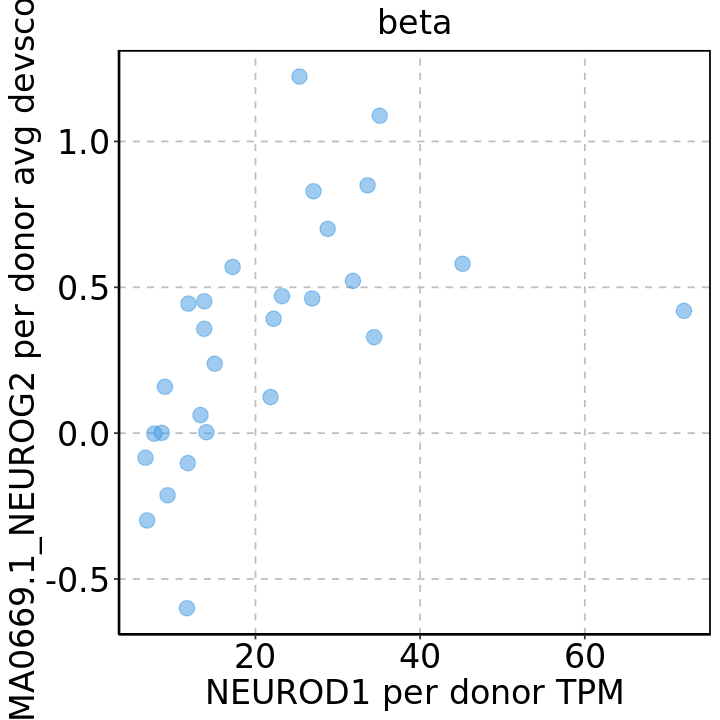

In [190]:
celltype <- 'beta'
motif <- 'MA0669.1_NEUROG2'
gene <- 'NEUROD1'
plot_motif_gene_comp(celltype, motif, gene)

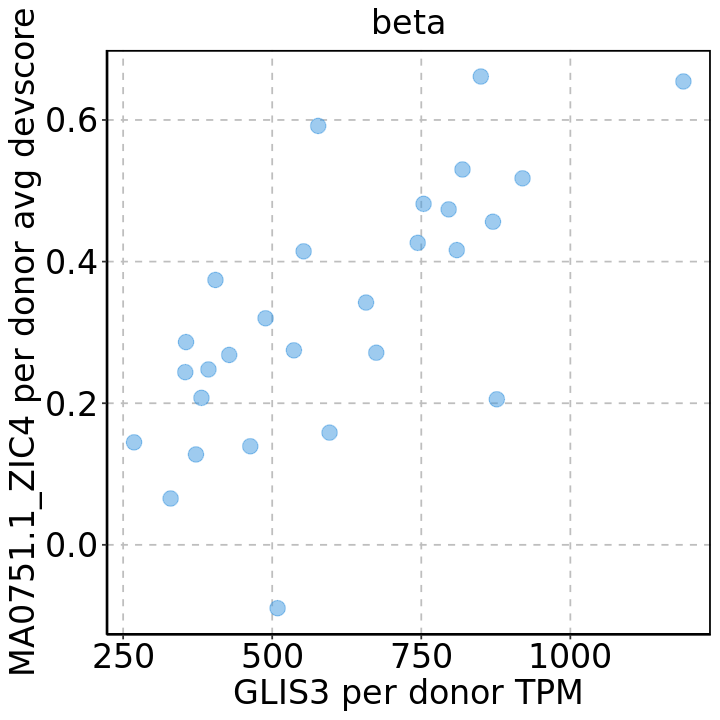

In [210]:
celltype <- 'beta'
motif <- 'MA0751.1_ZIC4'
gene <- 'GLIS3'
plot_motif_gene_comp(celltype, motif, gene)

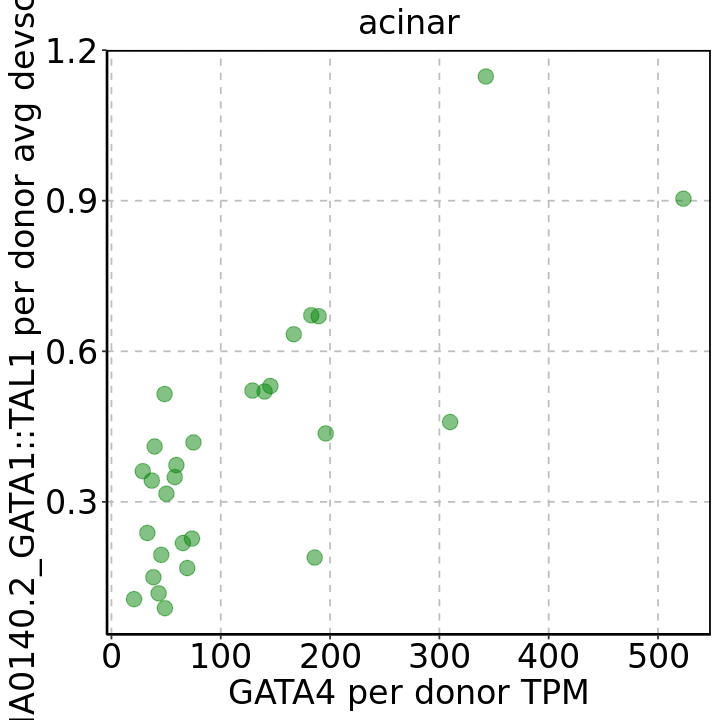

In [208]:
celltype <- 'acinar'
motif <- 'MA0140.2_GATA1::TAL1'
gene <- 'GATA4'
plot_motif_gene_comp(celltype, motif, gene)

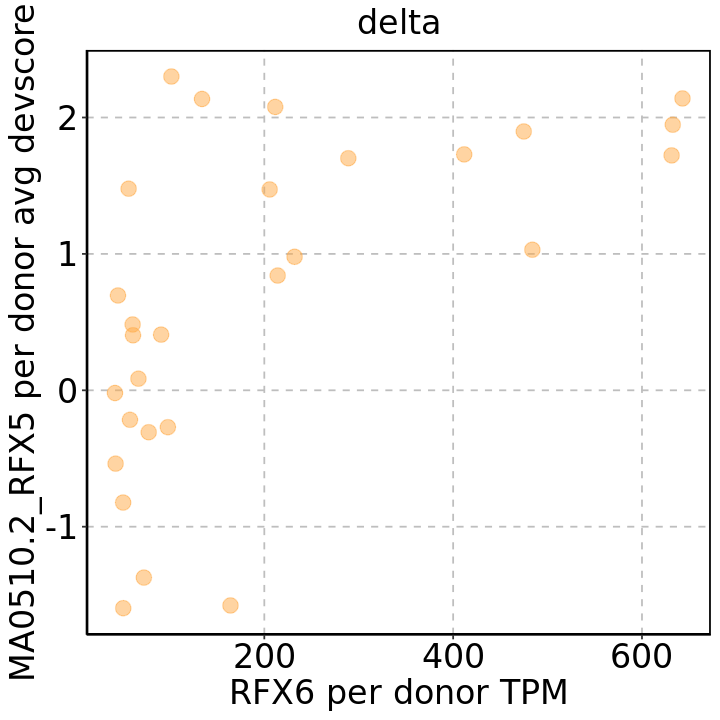

In [211]:
celltype <- 'delta'
motif <- 'MA0510.2_RFX5'
gene <- 'RFX6'
plot_motif_gene_comp(celltype, motif, gene)

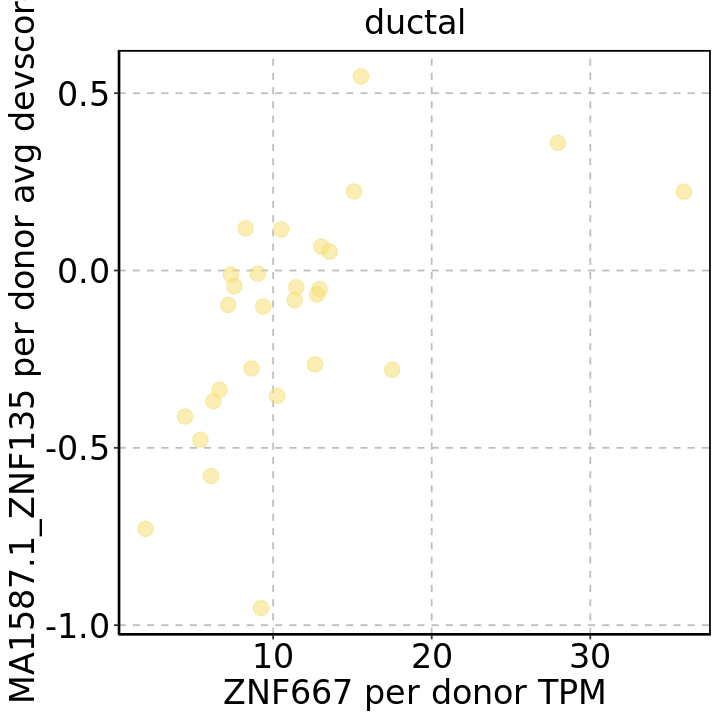

In [212]:
celltype <- 'ductal'
motif <- 'MA1587.1_ZNF135'
gene <- 'ZNF667'
plot_motif_gene_comp(celltype, motif, gene)

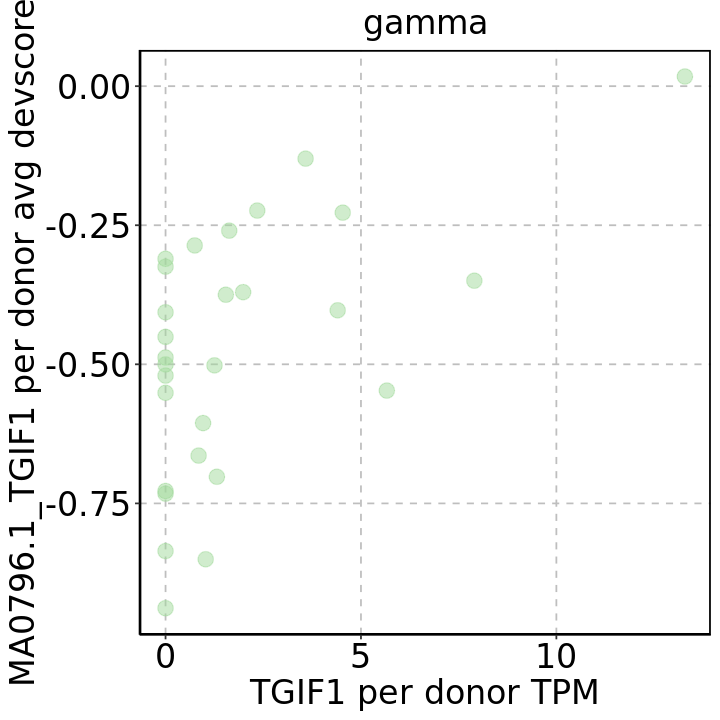

In [213]:
celltype <- 'gamma'
motif <- 'MA0796.1_TGIF1'
gene <- 'TGIF1'
plot_motif_gene_comp(celltype, motif, gene)

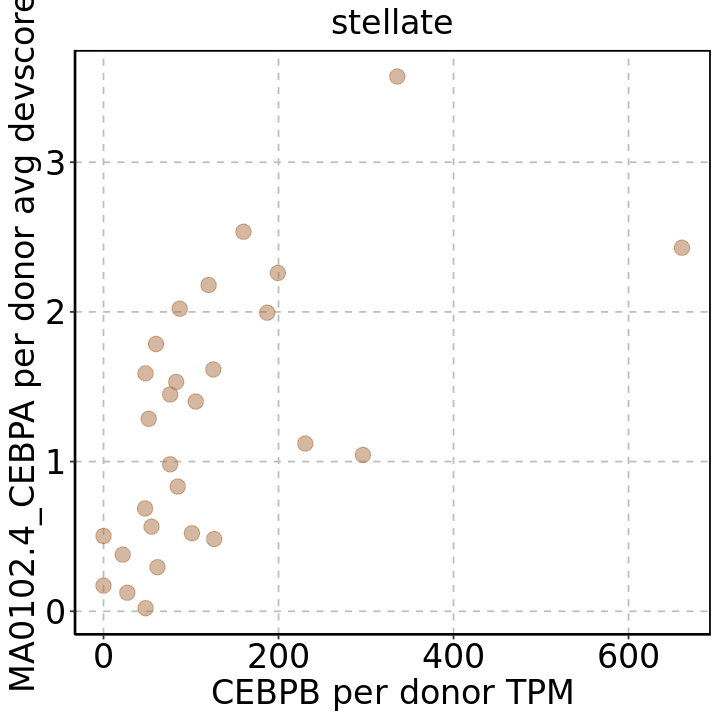

In [214]:
celltype <- 'stellate'
motif <- 'MA0102.4_CEBPA'
gene <- 'CEBPB'
plot_motif_gene_comp(celltype, motif, gene)